<a href="https://colab.research.google.com/github/ekalmes/Portfolio/blob/main/Zeke_Kalmes_Classification_Naive_Bayes_Spam_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Spam Filter
Author: Brad Sheese

---

NOTE: If you want to save your work select the following from the menu above:

**File  --> Save a copy in Drive**

If you work on the copy you made all changes will be saved to Google Drive. If you do not save your own copy, you can work in 'playground mode' instead, and any changes you make will be lost after you're done. 

In [ ]:
#@title Getting started? Execute this cell first.
#@markdown Click on the arrow to the left to execute this cell.

# set exercise name here
exercise_name = '12.0.3.0 Bayes Spam Filter'

import os
import sys

tool_path = '/content/cs125_tools/'

if not os.path.exists(tool_path):
  ! git clone --quiet https://github.com/bsheese/cs125_tools.git

if tool_path not in sys.path:
  sys.path.append(tool_path)

import exercise_report_response

exercise_report_response.exercise_time_difficulty_report(exercise_name)

,Time
30 min or less,0%
31-60 min,0%
61-90 min,0%
91-120 min,0%
More than 2 hours,0%


,Difficulty
Very Easy,0%
Somewhat Easy,0%
Neutral,0%
Somewhat Difficult,0%
Very Difficult,0%


# Introduction

In this exercise we are going to use Naive Bayes to build a spam filter, and to compare and contrast the effectiveness of different Naive Bayes classifiers. 




## Imports

In [ ]:
# general imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import random for test/train splits
import random

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# taken from https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb#scrollTo=AVvyDcMbTuqp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# import for cross validation
from sklearn.model_selection import train_test_split

# import metrics for assessing classification models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

## Helper Functions

These python functions will be used in order to simplify the process when it comes time to build and analyze the accuracy of the models. 

In [ ]:
# classification_comparisons is a modded version of the fxn provided by Prof. Sheese
# In exercise 12.0.0.2 
def classification_comparisons(X_train, y_train, X_test, y_test, stage):

  # instantiate your models
  log = LogisticRegression(class_weight='balanced', max_iter=4000)
  gnb = GaussianNB()
  mnb = MultinomialNB()
  rfc = RandomForestClassifier(n_estimators = 1500)

  # fit the data
  log.fit(X_train, y_train)
  gnb.fit(X_train, y_train)
  mnb.fit(X_train, y_train)
  rfc.fit(X_train, y_train)

  # make predictions
  log_predictions = log.predict(X_test)
  gnb_predictions = gnb.predict(X_test)
  mnb_predictions = mnb.predict(X_test)
  rfc_predictions = rfc.predict(X_test)

  # create classfication reports
  log_report = classification_report(y_test, log_predictions, output_dict=True)
  gnb_report = classification_report(y_test, gnb_predictions, output_dict=True)
  mnb_report = classification_report(y_test, mnb_predictions, output_dict=True)
  rfc_report = classification_report(y_test, rfc_predictions, output_dict=True)
  
  # convert reports to dataframes
  df_log = pd.DataFrame(log_report)
  df_log['model'] = 'logreg'
  
  df_gnb = pd.DataFrame(gnb_report)
  df_gnb['model'] = 'gnb'

  df_mnb = pd.DataFrame(mnb_report)
  df_mnb['model'] = 'mnb'
  
  df_rfc = pd.DataFrame(rfc_report)
  df_rfc['model'] = 'rfc'  


  # merge results 
  df = pd.concat([df_log, df_gnb, df_mnb, df_rfc]) 

  # move the model column to the front
  df = df[['model'] + [col for col in df.columns if col != 'model']]
  
  # set stage
  df['stage'] = stage
  
  return df


## Data

Data is called 'spambase', hosted on the UCI machine learning database.


From the documentation
'''
Sources:
   (a) Creators: Mark Hopkins, Erik Reeber, George Forman, Jaap Suermondt
        Hewlett-Packard Labs, 1501 Page Mill Rd., Palo Alto, CA 94304
   (b) Donor: George Forman (gforman at nospam hpl.hp.com)  650-857-7835
   (c) Generated: June-July 1999


Variables:

* 48 continuous real [0,100] attributes of type word_freq_WORD = percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.  A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric 
characters or end-of-string.

* 6 continuous real [0,100] attributes of type char_freq_CHAR = percentage of characters in the e-mail that match CHAR,i.e. 100 * (number of CHAR occurences) / total characters in e-mail

* 1 continuous real [1,...] attribute of type capital_run_length_average
= average length of uninterrupted sequences of capital letters

* 1 continuous integer [1,...] attribute of type capital_run_length_longest
= length of longest uninterrupted sequence of capital letters

* 1 continuous integer [1,...] attribute of type capital_run_length_total
= sum of length of uninterrupted sequences of capital letters
= total number of capital letters in the e-mail

* 1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), 
i.e. unsolicited commercial e-mail.  

In [ ]:
# retrieve the data, build the dataframe
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data',
                 header=None)

# variable names
col_names = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over',
 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive',
 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free',
 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font',
 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650',
 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415',
 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm',
 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project',
 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_semicolon',
 'char_freq_parenthesis', 'char_freq_bracket', 'char_freq_exclamation', 'char_freq_dollarsign',
 'char_freq_poundsign', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'spam']

# apply variable names
df.columns = col_names

## Instructions

* Use the following classifieres to predict spam:
  * Logistic regression
  * Guassian Naive Bayes
  * Multinomial Naive Bayes
  * One other classifier of your choosing


* Control your test-train split randomization to insure you are comparing your classifier accuracy against the same data
* Rerun your analysis multiple times before drawing a conclusion

## Basic Dataframe Statistics
Here I will be looking at the dataframe to check data types, null values, and basic distributions. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

First, it is apparent that all of the variables are already of numeric types which allows them to be entered into the models. In addition, there appears to be no null values, as all of the features have the same amount of non-null values. 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.104553,0.305358,0.0,0.000,0.000,0.000,4.540
word_freq_address,4601.0,0.213015,1.290575,0.0,0.000,0.000,0.000,14.280
word_freq_all,4601.0,0.280656,0.504143,0.0,0.000,0.000,0.420,5.100
word_freq_3d,4601.0,0.065425,1.395151,0.0,0.000,0.000,0.000,42.810
word_freq_our,4601.0,0.312223,0.672513,0.0,0.000,0.000,0.380,10.000
word_freq_over,4601.0,0.095901,0.273824,0.0,0.000,0.000,0.000,5.880
word_freq_remove,4601.0,0.114208,0.391441,0.0,0.000,0.000,0.000,7.270
word_freq_internet,4601.0,0.105295,0.401071,0.0,0.000,0.000,0.000,11.110
word_freq_order,4601.0,0.090067,0.278616,0.0,0.000,0.000,0.000,5.260
word_freq_mail,4601.0,0.239413,0.644755,0.0,0.000,0.000,0.160,18.180


It might not initially apparent what useful information this provides; however, after a second look, the IQRs show that a majority of the features have a substantial amount of zero values. This will be further analyzed in the distributions section. 

## Check Outcome
Here I will look at the outcome variable, spam, to see how it is distributed. 

In [ ]:
df['spam'].value_counts()

0    2788
1    1813
Name: spam, dtype: int64

It is seen that the spam variable is already binary coded, which is what I need. Also, there is only around a third of the emails that were flagged as spam.

## Check Duplicates
Here I will be checking to see if there are any duplicate rows. 

In [ ]:
df.duplicated().value_counts()

False    4210
True      391
dtype: int64

Wow, 391 duplicated rows, that's a substantial amount. When thinking about the dataset, this probably means that there were duplicated emails counted in the dataset. Since this analysis is focused on predicting whether or not an email is spam, and not how many spam emails someone is getting, I will drop these rows as they only add noise to the models. 

In [ ]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(4601, 58)
(4210, 58)


After doing some quick mental math, I can confirm that all the duplicate rows have been dropped. 

## Check Distributions
Here I will be outputting histplots and a countplot for the features and the outcome variables in order to more closely look at the distributions mentioned earlier. 

In [ ]:
# for loop to loop through all of the columns and output different graphs based on number of unique values
# for col in df.columns:
#   if df[col].nunique() > 2:
#     sns.histplot(x = df[col])
#   else:
#     sns.countplot(x = df[col])
#   plt.title(col)
#   plt.show()

The conclusion from the statistics section is confirmed, there are a significant amount of zero values in all of the features. This means the logisitc regression will probably be thrown off a bit, as it relies on normal distributions, but it will not matter for either of the Naive-Bayes models or the random tree classifier model. 

## Check Collinearity
Here I will be correlating the variables to check for collinearity in the features. 

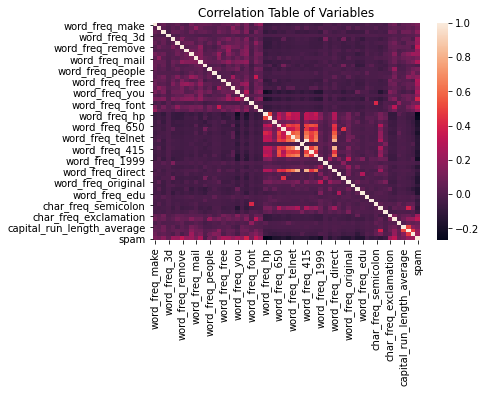

In [ ]:
sns.heatmap(df.corr())
plt.title('Correlation Table of Variables')
plt.show()

On the outskirts, there don't appear to be any issues with collinearity. I want to take a closer look at the central region where there is more correlation.

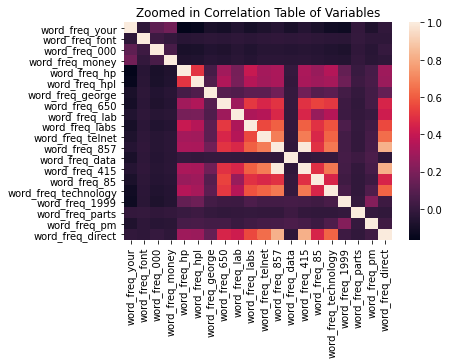

In [ ]:
sns.heatmap(df.iloc[:,20:40].corr())
plt.title('Zoomed in Correlation Table of Variables')
plt.show()

There seems to be a very high correlation between  word_freq_415 and word_freq_857.

In [ ]:
df[['word_freq_415', 'word_freq_857']].corr()

,word_freq_415,word_freq_857
word_freq_415,1.000000,0.994875
word_freq_857,0.994875,1.000000


Woooaaahhhhh. Way too high of a correlation. This is going to cause my models some trouble, so I need to drop one of these columns. I chose word_freq_857. 

In [ ]:
# dropping redundant columns
df = df.drop('word_freq_857', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4210 entries, 0 to 4600
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4210 non-null   float64
 1   word_freq_address           4210 non-null   float64
 2   word_freq_all               4210 non-null   float64
 3   word_freq_3d                4210 non-null   float64
 4   word_freq_our               4210 non-null   float64
 5   word_freq_over              4210 non-null   float64
 6   word_freq_remove            4210 non-null   float64
 7   word_freq_internet          4210 non-null   float64
 8   word_freq_order             4210 non-null   float64
 9   word_freq_mail              4210 non-null   float64
 10  word_freq_receive           4210 non-null   float64
 11  word_freq_will              4210 non-null   float64
 12  word_freq_people            4210 non-null   float64
 13  word_freq_report            4210 

Boom! Sorry word_freq_857, you are the imposter. 

Will no null values, all duplicates dropped, collinearity addressed, and no need to scale the variables, it is time to build the models. 

## Model Building and Comparisons
Here the models will be built, and a table of the resulting accuracies from different train/test splits will be displayed using the helper function classification_comparisons. 

In [ ]:
# define features (X) and outcome (y)
# drop spam from features
X = df.drop('spam', axis = 1)
y = df['spam']

df_list = []
# for loop to build models using random test/train splits and call helper function
for stage in range(3):
  rs_set = random.randint(0, 4601)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state = rs_set)
  print('Random split set as: ', rs_set)
  df = classification_comparisons(X_train, y_train, X_test, y_test, stage)
  df.loc['f1-score',['model','accuracy']].set_index('model')
  df_list.append(df)

Random split set as:  3160
Random split set as:  969
Random split set as:  3536


In [ ]:
df_results = pd.concat([df_list[0], df_list[1], df_list[2]])
df_results_grouped = df_results.reset_index().groupby(by=['model','stage']).mean()
df_results_grouped['accuracy']

model   stage
gnb     0        0.812915
        1        0.836657
        2        0.835708
logreg  0        0.924027
        1        0.927825
        2        0.934473
mnb     0        0.811966
        1        0.805318
        2        0.792023
rfc     0        0.947768
        1        0.945869
        2        0.953466
Name: accuracy, dtype: float64

A bit of a surprise here. Even without normalization, logistic regression is one of the top models in terms of accuracy. The best model according to accuracy is random forest classifiers. 

In [ ]:
df_results_grouped_2 = df_results.reset_index().groupby(by=['model'])
df_results_grouped_2.head(100)

,index,model,0,1,accuracy,macro avg,weighted avg,stage
0,precision,logreg,0.949593,0.888128,0.924027,0.918861,0.925077,0
1,recall,logreg,0.922591,0.926190,0.924027,0.924391,0.924027,0
2,f1-score,logreg,0.935897,0.906760,0.924027,0.921329,0.924276,0
3,support,logreg,633.000000,420.000000,0.924027,1053.000000,1053.000000,0
4,precision,gnb,0.943089,0.698752,0.812915,0.820921,0.845633,0
5,recall,gnb,0.733017,0.933333,0.812915,0.833175,0.812915,0
6,f1-score,gnb,0.824889,0.799185,0.812915,0.812037,0.814636,0
7,support,gnb,633.000000,420.000000,0.812915,1053.000000,1053.000000,0
8,precision,mnb,0.838258,0.770732,0.811966,0.804495,0.811325,0
9,recall,mnb,0.851501,0.752381,0.811966,0.801941,0.811966,0


This table demonstrates the precision, recall, and f1 scores for all of the models in each stage, as well as for whether or not the email was detected as spam. 

## Conclusion: 
In spam detection we care alot more about some kinds of errors than others. Think about what kind of error you want to miminize the most in spam detection and how what might effect your choice of classifier. Which one seems best suited for use in spam detection in your modelling? Be very explicit, why do you think its the best?

In [ ]:
#@title Response
problem1 = "The error I would like to minimize is false positives, as I don't want emails that aren't spam to be flagged as spam. When thinking about which outcome to focus on, 1 (spam) or 0 (not spam), it make sense to minimize the error of not spam in order to not accidentally put an important email into the spam folder. According to the f1 scores, random forests have the highest average f1 score for the 0 outcome over the 3 different test/train splits, therefore I assume that random forest classifiers are the best model to use. " #@param {type:"string"}


---

In [ ]:
#@title Completed the exercise? 
#@markdown Click on the arrow to the left to create the response form.

import sys
if 'exercise_report_response' not in sys.modules:
  print('Please execute the "Getting Started" cell at the beginning of this exercise, then rerun this cell.')
else:
  exercise_report_response.display_form(exercise_report_response.er_question_list)

If this form does not display correctly in Colab, select "Runttime" from the menu at the top, then select "Restart and run all"
Your first name:


Text(value='Zeke', placeholder='Enter your first name here')


Your last name:


Text(value='Kalmes', placeholder='Enter your last name here')


How difficult was the exercise?


ToggleButtons(button_style='warning', index=3, options=('Very Easy', 'Somewhat Easy', 'Neutral', 'Somewhat Dif…


How long did it take you to complete the exercise?


ToggleButtons(button_style='warning', index=3, options=('30 min or less', '31-60 min', '61-90 min', '91-120 mi…


What tools (or concepts) used in this exercise do you feel confident with?


Textarea(value='cleaning the data and building the models', placeholder='Enter your response here')


What tools (or concepts) do you still need practice with?


Textarea(value='the output table gave me some trouble but after some tweaking it got better. Also interpreting…


What suggestions do you have for improving the exercise?


Textarea(value='none ', placeholder='Enter your response here')


What corrections should be made (typos. etc)?


Textarea(value="In spam detection we care alot more about some kinds of errors than others. Think about what k…


Share your notebook.
Select 'Share' at the top of the screen. Then select 'Get Link'.
Change the Link so anyone can view it.
Click 'Copy Link', then 'Done'. Paste the link here.


Textarea(value='https://colab.research.google.com/drive/1HmDyswz_TyVFRexMpnX4YZTquiJ_srvG?usp=sharing', placeh…

In [ ]:
#@title Ready to Submit?
#@markdown If you have completed the exercise and the exercise response:
#@markdown * check the box 'Ready' box below 
#@markdown * execute this cell

Ready = False #@param {type:"boolean"}

try:
  if Ready == True:
    exercise_report_response.submit_exercise_response(exercise_name, exercise_report_response.er_question_list)

  else:
    print('NOT SUBMITTED!!!')
    print('Check the ready box if you are ready to submit your response.')

except:
  print('NOT SUBMITTED!!!')
  print('Execute the cell above to create the form.')

NOT SUBMITTED!!!
Check the ready box if you are ready to submit your response.
